# 🧬 Omics AI Explorer Python Library - Quick Start

This notebook demonstrates how to use the Omics AI Explorer Python library to access genomics data across multiple Explorer networks including HiFi Solves, Neuroscience AI, and more.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mfiume/omics-ai-python-library/blob/main/Omics_AI_Explorer_Quick_Start.ipynb)

## 🌟 What You'll Learn

- Install and import the Omics AI Explorer library
- Connect to different Explorer networks
- List available collections and tables
- Inspect table schemas
- Perform queries on genomics data
- Work with real genomics datasets

## 📦 Installation

First, let's install the Omics AI Explorer library. We'll use a robust installation method that works reliably in Google Colab:

In [ ]:
import json
import re
import time
from typing import Dict, List, Optional, Any, Union
from urllib.parse import urlencode, quote
import requests

class OmicsAIError(Exception):
    """Base exception for Omics AI client errors."""
    pass

class AuthenticationError(OmicsAIError):
    """Raised when authentication fails."""
    pass

class NetworkError(OmicsAIError):
    """Raised when network requests fail."""
    pass

class ValidationError(OmicsAIError):
    """Raised when input validation fails."""
    pass

def parse_json_lines_response(raw_text: str, debug: bool = False) -> Dict[str, Any]:
    """
    Parse JSON Lines response format from Explorer APIs.
    
    Expected format:
    {}
    {}
    {}
    {"data": [...], "pagination": {...}, "data_model": {...}}
    """
    if debug:
        print(f"🔍 Debug: Raw response length: {len(raw_text)}")
        print(f"🔍 Debug: First 200 chars: {raw_text[:200]}")
    
    if not raw_text.strip():
        raise OmicsAIError("Empty response received")
    
    # Split by lines and filter out empty lines
    lines = [line.strip() for line in raw_text.strip().split('\n') if line.strip()]
    
    if debug:
        print(f"🔍 Debug: Found {len(lines)} non-empty lines")
        for i, line in enumerate(lines[:5]):  # Show first 5 lines
            print(f"🔍 Debug: Line {i+1}: {line[:100]}...")
    
    if not lines:
        raise OmicsAIError("No valid lines found in response")
    
    # Parse each line as JSON
    json_objects = []
    for i, line in enumerate(lines):
        try:
            obj = json.loads(line)
            json_objects.append(obj)
            if debug:
                print(f"🔍 Debug: Parsed line {i+1}: {list(obj.keys()) if obj else 'empty object'}")
        except json.JSONDecodeError as e:
            # Skip empty objects {} but report other parsing errors
            if line != "{}":
                print(f"⚠️ Failed to parse line {i+1}: {line[:50]}... - {e}")
            if debug:
                print(f"🔍 Debug: Failed to parse line {i+1}: {line}")
    
    if debug:
        print(f"🔍 Debug: Parsed {len(json_objects)} JSON objects")
        for i, obj in enumerate(json_objects):
            print(f"🔍 Debug: Object {i+1} keys: {list(obj.keys()) if obj else 'empty'}")
    
    if not json_objects:
        raise OmicsAIError("No valid JSON objects found in response")
    
    # Find the object with data (usually the last non-empty one)
    for obj in reversed(json_objects):
        if obj and 'data' in obj:
            if debug:
                print(f"🔍 Debug: Found data object with {len(obj['data'])} rows")
            return obj
    
    # If no data object found, check for next_page_token (polling case)
    for obj in reversed(json_objects):
        if obj and 'next_page_token' in obj:
            if debug:
                print(f"🔍 Debug: Found next_page_token: {obj['next_page_token'][:50]}...")
            return obj
    
    # If we get here, we have only empty objects {} or unexpected format
    if all(not obj for obj in json_objects):
        # All empty objects - this might be a polling response
        if debug:
            print("🔍 Debug: All objects are empty, treating as polling case")
        return {"next_page_token": "empty_response_poll"}
    
    # Return the last non-empty object
    non_empty_objects = [obj for obj in json_objects if obj]
    if non_empty_objects:
        result = non_empty_objects[-1]
        if debug:
            print(f"🔍 Debug: Returning last non-empty object with keys: {list(result.keys())}")
        return result
    
    raise OmicsAIError(f"No data or next_page_token found. Objects: {json_objects}")

class OmicsAIClient:
    """
    Client for interacting with Omics AI Explorer instances.
    
    This client provides a simple interface to:
    - List collections across different Explorer networks
    - List tables within collections
    - Get table schemas
    - Perform queries on tables
    """
    
    # Common Explorer instances
    KNOWN_NETWORKS = {
        "hifisolves": "hifisolves.org",
        "neuroscience": "neuroscience.ai", 
        "asap": "cloud.parkinsonsroadmap.org",  # Aligning Science Across Parkinson's
        "parkinsons": "cloud.parkinsonsroadmap.org",  # Keep backward compatibility
        "biomedical": "biomedical.ai",
        "viral": "viral.ai",
        "targetals": "dataportal.targetals.org"  # Target ALS
    }
    
    def __init__(self, network: str = "hifisolves.org", access_token: Optional[str] = None):
        """
        Initialize the Omics AI client.
        
        Args:
            network: The Explorer network domain (e.g., 'hifisolves.org') or short name
            access_token: Optional access token for authenticated requests
        """
        # Handle short network names
        if network in self.KNOWN_NETWORKS:
            network = self.KNOWN_NETWORKS[network]
            
        # Ensure network has protocol
        if not network.startswith(('http://', 'https://')):
            network = f"https://{network}"
            
        self.network = network.rstrip('/')
        self.access_token = access_token
        self.session = requests.Session()
        
        # Set up default headers
        headers = {
            'User-Agent': 'omics-ai-python-client/0.1.0',
            'Accept': 'application/json'
        }
        
        if self.access_token:
            headers['Authorization'] = f'Bearer {self.access_token}'
            
        self.session.headers.update(headers)
    
    def _make_request(self, method: str, endpoint: str, **kwargs) -> requests.Response:
        """Make an HTTP request to the Explorer API."""
        url = f"{self.network}{endpoint}"
        
        try:
            response = self.session.request(method, url, **kwargs)
            response.raise_for_status()
            return response
        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 401:
                raise AuthenticationError(f"Authentication failed: {e}")
            elif e.response.status_code == 403:
                raise AuthenticationError(f"Access forbidden: {e}")
            else:
                raise OmicsAIError(f"HTTP error {e.response.status_code}: {e}")
        except requests.exceptions.RequestException as e:
            raise NetworkError(f"Network error: {e}")
    
    def list_collections(self) -> List[Dict[str, Any]]:
        """List all collections in this Explorer network."""
        response = self._make_request('GET', '/api/collections')
        collections = response.json()
        
        if not isinstance(collections, list):
            raise OmicsAIError("Expected list of collections but got something else")
            
        return collections
    
    def list_tables(self, collection_slug: str) -> List[Dict[str, Any]]:
        """List all tables in a collection."""
        if not collection_slug:
            raise ValidationError("Collection slug is required")
            
        endpoint = f"/api/collections/{quote(collection_slug)}/tables"
        response = self._make_request('GET', endpoint)
        tables = response.json()
        
        if not isinstance(tables, list):
            raise OmicsAIError("Expected list of tables but got something else")
            
        return tables
    
    def get_schema_fields(self, collection_slug: str, table_name: str) -> List[Dict[str, str]]:
        """Get a simplified list of fields from a table schema."""
        endpoint = f"/api/collection/{quote(collection_slug)}/data-connect/table/{quote(table_name)}/info"
        response = self._make_request('GET', endpoint)
        schema = response.json()
        
        data_model = schema.get('data_model', {}).get('properties', {})
        
        if not data_model:
            raise OmicsAIError("No schema (data_model.properties) found in response")
            
        fields = []
        for field_name, field_spec in data_model.items():
            # Handle type which can be a string or list
            field_type = field_spec.get('type', '')
            if isinstance(field_type, list):
                field_type = ', '.join(field_type)
            
            # Handle array types with items
            if field_type == 'array' and 'items' in field_spec:
                item_type = field_spec['items'].get('type', '')
                if isinstance(item_type, list):
                    item_type = ', '.join(item_type)
                field_type = f"array<{item_type}>"
            
            fields.append({
                'field': field_name,
                'type': field_type,
                'sql_type': field_spec.get('sqlType', '')
            })
            
        return fields
    
    def query_with_polling(self, 
                          collection_slug: str, 
                          table_name: str, 
                          filters: Optional[Dict[str, Any]] = None,
                          limit: int = 100,
                          offset: int = 0,
                          max_polls: int = 10,
                          poll_interval: float = 2.0,
                          debug: bool = False) -> Dict[str, Any]:
        """
        Query a table with polling for async results.
        
        The query endpoint is asynchronous across all Explorer networks:
        1. First call returns next_page_token but no data
        2. Poll with the token until data is ready
        3. Eventually get data array + next_page_tokens for pagination
        """
        if not collection_slug or not table_name:
            raise ValidationError("Both collection_slug and table_name are required")
            
        if filters is None:
            filters = {}
            
        payload = {
            "tableName": table_name,
            "filters": filters,
            "pagination": {
                "limit": limit,
                "offset": offset
            }
        }
        
        endpoint = f"/api/collections/{quote(collection_slug)}/tables/{quote(table_name)}/filter"
        
        if debug:
            print(f"🔍 Debug: Endpoint: {self.network}{endpoint}")
            print(f"🔍 Debug: Payload: {json.dumps(payload, indent=2)}")
        
        print(f"🔄 Starting async query (max {max_polls} polls, {poll_interval}s interval)...")
        
        for poll_count in range(max_polls):
            response = self._make_request(
                'POST', 
                endpoint,
                json=payload,
                headers={'Content-Type': 'application/json'}
            )
            
            if debug:
                print(f"🔍 Debug: Poll {poll_count + 1} response status: {response.status_code}")
                print(f"🔍 Debug: Response headers: {dict(response.headers)}")
            
            # Parse JSON Lines response using the new parser
            try:
                result = parse_json_lines_response(response.text, debug=debug)
            except OmicsAIError as e:
                raise OmicsAIError(f"Failed to parse response: {e}")
            
            # Check if we have data or need to poll
            if 'data' in result and isinstance(result['data'], list):
                print(f"✅ Data ready after {poll_count + 1} poll(s)!")
                return result
            elif 'next_page_token' in result or result.get('next_page_token') == 'empty_response_poll':
                print(f"   Poll {poll_count + 1}/{max_polls}: Data not ready, polling again in {poll_interval}s...")
                # Update payload with next page token for polling (if not empty response)
                if result.get('next_page_token') != 'empty_response_poll':
                    payload['next_page_token'] = result['next_page_token']
                time.sleep(poll_interval)
            else:
                raise OmicsAIError(f"Unexpected response format: {list(result.keys())}")
        
        raise OmicsAIError(f"Query timed out after {max_polls} polls ({max_polls * poll_interval}s)")
    
    def query(self, 
              collection_slug: str, 
              table_name: str, 
              filters: Optional[Dict[str, Any]] = None,
              limit: int = 100,
              offset: int = 0) -> Dict[str, Any]:
        """Query a table with optional filters and pagination (with auto-polling for all networks)."""
        return self.query_with_polling(collection_slug, table_name, filters, limit, offset)

print("✅ Omics AI client loaded successfully!")

In [ ]:
# Import the Omics AI Explorer library with fallback options

try:
    # Try normal import first
    from omics_ai import OmicsAIClient
    print("✅ Successfully imported OmicsAIClient from installed package!")
    
except ImportError:
    print("⚠️ Package import failed, trying fallback method...")
    
    try:
        # Fallback: Add the cloned repository to path
        import sys
        sys.path.insert(0, '/content/omics-ai-python-library')
        from omics_ai import OmicsAIClient
        print("✅ Successfully imported from cloned repository!")
        
    except ImportError:
        try:
            # Try local files
            sys.path.insert(0, '/content/omics_ai_local')
            from client import OmicsAIClient
            print("✅ Successfully imported from downloaded files!")
        except ImportError:
            print("⚠️ All import methods failed, using inline implementation...")
            
            # Last resort: Define the client class inline
            import requests
            import json
            import re
            import time
            from typing import Dict, List, Optional, Any
            from urllib.parse import quote
            
            def parse_json_lines_response_fallback(raw_text: str, debug: bool = False) -> Dict[str, Any]:
                """Parse JSON Lines response - simplified version for fallback with debug support."""
                if debug:
                    print(f"🔍 Debug: Raw response length: {len(raw_text)}")
                    print(f"🔍 Debug: First 200 chars: {raw_text[:200]}")
                    
                if not raw_text.strip():
                    raise Exception("Empty response received")
                
                lines = [line.strip() for line in raw_text.strip().split('\n') if line.strip()]
                
                if debug:
                    print(f"🔍 Debug: Found {len(lines)} non-empty lines")
                    for i, line in enumerate(lines[:5]):
                        print(f"🔍 Debug: Line {i+1}: {line[:100]}...")
                
                json_objects = []
                
                for i, line in enumerate(lines):
                    try:
                        obj = json.loads(line)
                        json_objects.append(obj)
                        if debug:
                            print(f"🔍 Debug: Parsed line {i+1}: {list(obj.keys()) if obj else 'empty object'}")
                    except json.JSONDecodeError:
                        if line != "{}":
                            print(f"⚠️ Failed to parse line: {line[:50]}...")
                        if debug:
                            print(f"🔍 Debug: Failed to parse line {i+1}: {line}")
                
                if debug:
                    print(f"🔍 Debug: Parsed {len(json_objects)} JSON objects")
                    for i, obj in enumerate(json_objects):
                        print(f"🔍 Debug: Object {i+1} keys: {list(obj.keys()) if obj else 'empty'}")
                
                # Find object with data
                for obj in reversed(json_objects):
                    if obj and 'data' in obj:
                        if debug:
                            print(f"🔍 Debug: Found data object with {len(obj['data'])} rows")
                        return obj
                
                # Check for polling tokens
                for obj in reversed(json_objects):
                    if obj and 'next_page_token' in obj:
                        if debug:
                            print(f"🔍 Debug: Found next_page_token: {obj['next_page_token'][:50]}...")
                        return obj
                
                # Handle all empty objects
                if all(not obj for obj in json_objects):
                    if debug:
                        print("🔍 Debug: All objects are empty, treating as polling case")
                    return {"next_page_token": "empty_response_poll"}
                
                # Return last non-empty
                non_empty = [obj for obj in json_objects if obj]
                if non_empty:
                    result = non_empty[-1]
                    if debug:
                        print(f"🔍 Debug: Returning last non-empty object with keys: {list(result.keys())}")
                    return result
                
                raise Exception(f"No data found. Objects: {json_objects}")
            
            class OmicsAIClient:
                """Simplified Omics AI Explorer client for Colab with JSON Lines parsing and debug support."""
                
                KNOWN_NETWORKS = {
                    "hifisolves": "hifisolves.org",
                    "neuroscience": "neuroscience.ai", 
                    "asap": "cloud.parkinsonsroadmap.org",  # Aligning Science Across Parkinson's
                    "parkinsons": "cloud.parkinsonsroadmap.org",  # Keep backward compatibility
                    "biomedical": "biomedical.ai",
                    "viral": "viral.ai",
                    "targetals": "dataportal.targetals.org"  # Target ALS
                }
                
                def __init__(self, network: str = "hifisolves.org", access_token: Optional[str] = None):
                    if network in self.KNOWN_NETWORKS:
                        network = self.KNOWN_NETWORKS[network]
                    if not network.startswith(('http://', 'https://')):
                        network = f"https://{network}"
                        
                    self.network = network.rstrip('/')
                    self.access_token = access_token
                    self.session = requests.Session()
                    
                    headers = {'User-Agent': 'omics-ai-colab-client', 'Accept': 'application/json'}
                    if self.access_token:
                        headers['Authorization'] = f'Bearer {self.access_token}'
                    self.session.headers.update(headers)
                
                def _make_request(self, method: str, endpoint: str, **kwargs):
                    url = f"{self.network}{endpoint}"
                    response = self.session.request(method, url, **kwargs)
                    response.raise_for_status()
                    return response
                
                def list_collections(self) -> List[Dict[str, Any]]:
                    response = self._make_request('GET', '/api/collections')
                    return response.json()
                
                def list_tables(self, collection_slug: str) -> List[Dict[str, Any]]:
                    endpoint = f"/api/collections/{quote(collection_slug)}/tables"
                    response = self._make_request('GET', endpoint)
                    return response.json()
                
                def get_schema_fields(self, collection_slug: str, table_name: str) -> List[Dict[str, str]]:
                    endpoint = f"/api/collection/{quote(collection_slug)}/data-connect/table/{quote(table_name)}/info"
                    response = self._make_request('GET', endpoint)
                    schema = response.json()
                    
                    data_model = schema.get('data_model', {}).get('properties', {})
                    fields = []
                    for field_name, field_spec in data_model.items():
                        field_type = field_spec.get('type', '')
                        if isinstance(field_type, list):
                            field_type = ', '.join(field_type)
                        if field_type == 'array' and 'items' in field_spec:
                            item_type = field_spec['items'].get('type', '')
                            if isinstance(item_type, list):
                                item_type = ', '.join(item_type)
                            field_type = f"array<{item_type}>"
                        
                        fields.append({
                            'field': field_name,
                            'type': field_type,
                            'sql_type': field_spec.get('sqlType', '')
                        })
                    return fields
                
                def query_with_polling(self, collection_slug: str, table_name: str, 
                                     filters=None, limit: int = 100, offset: int = 0,
                                     max_polls: int = 10, poll_interval: float = 2.0, 
                                     debug: bool = False) -> Dict[str, Any]:
                    """Query with JSON Lines parsing and async polling support with debug mode."""
                    if filters is None:
                        filters = {}
                        
                    payload = {
                        "tableName": table_name,
                        "filters": filters,
                        "pagination": {"limit": limit, "offset": offset}
                    }
                    
                    endpoint = f"/api/collections/{quote(collection_slug)}/tables/{quote(table_name)}/filter"
                    
                    if debug:
                        print(f"🔍 Debug: Endpoint: {self.network}{endpoint}")
                        print(f"🔍 Debug: Payload: {json.dumps(payload, indent=2)}")
                    
                    print(f"🔄 Starting async query (max {max_polls} polls, {poll_interval}s interval)...")
                    
                    for poll_count in range(max_polls):
                        response = self._make_request('POST', endpoint, json=payload)
                        
                        if debug:
                            print(f"🔍 Debug: Poll {poll_count + 1} response status: {response.status_code}")
                            print(f"🔍 Debug: Response headers: {dict(response.headers)}")
                        
                        # Use the new JSON Lines parser with debug support
                        try:
                            result = parse_json_lines_response_fallback(response.text, debug=debug)
                        except Exception as e:
                            raise Exception(f"Failed to parse response: {e}")
                        
                        # Check if we have data or need to poll
                        if 'data' in result and isinstance(result['data'], list):
                            print(f"✅ Data ready after {poll_count + 1} poll(s)!")
                            return result
                        elif 'next_page_token' in result or result.get('next_page_token') == 'empty_response_poll':
                            print(f"   Poll {poll_count + 1}/{max_polls}: Data not ready, polling again in {poll_interval}s...")
                            if result.get('next_page_token') != 'empty_response_poll':
                                payload['next_page_token'] = result['next_page_token']
                            time.sleep(poll_interval)
                        else:
                            return result  # Return whatever we got
                    
                    raise Exception(f"Query timed out after {max_polls} polls")
                
                def query(self, collection_slug: str, table_name: str, limit: int = 100, **kwargs) -> Dict[str, Any]:
                    """Query with auto-polling and JSON Lines parsing."""
                    return self.query_with_polling(collection_slug, table_name, limit=limit)
                
                def count(self, collection_slug: str, table_name: str) -> int:
                    endpoint = f"/api/collections/{quote(collection_slug)}/tables/{quote(table_name)}/filter/count"
                    response = self._make_request('POST', endpoint, json={"filters": {}})
                    
                    try:
                        result = parse_json_lines_response_fallback(response.text)
                        return result.get('count', 0)
                    except:
                        return 0
            
            print("✅ Using inline client implementation with JSON Lines parsing and debug support!")

# Import additional libraries for data analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import time

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ All imports successful!")
print(f"📅 Notebook run at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

## 🔧 Import and Setup

Now let's import the library and set up our environment:

In [3]:
# Import the Omics AI Explorer library
from omics_ai import OmicsAIClient

# Import additional libraries for data analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ All imports successful!")
print(f"📅 Notebook run at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All imports successful!
📅 Notebook run at: 2025-06-10 18:00:03


In [ ]:
# Explore different Omics AI networks
networks = {
    "HiFi Solves": "hifisolves",
    "Biomedical AI": "biomedical", 
    "Neuroscience AI": "neuroscience",
    "Viral AI": "viral",
    "ASAP (Parkinson's)": "asap",
    "Target ALS": "targetals"
}

total_collections = 0
network_results = {}

for network_name, network_key in networks.items():
    print(f"🔗 Connecting to {network_name}...")
    try:
        client = OmicsAIClient(network_key)
        collections = client.list_collections()
        collection_count = len(collections)
        total_collections += collection_count
        network_results[network_name] = collection_count
        print(f"✅ {network_name}: {collection_count} collections")
    except Exception as e:
        print(f"❌ {network_name}: {e}")
        network_results[network_name] = 0

print(f"\n📊 Network Summary:")
print(f"   Total collections across all networks: {total_collections}")
for network_name, count in network_results.items():
    if count > 0:
        print(f"   {network_name}: {count} collections")

In [ ]:
# Available Explorer networks
networks = {
    "HiFi Solves": "hifisolves",
    "Biomedical AI": "biomedical", 
    "Neuroscience AI": "neuroscience",
    "Viral AI": "viral",
    "ASAP (Parkinson's)": "asap",
    "Target ALS": "targetals"
}

print("🌐 Exploring Omics AI Explorer Networks")
print("=" * 50)

network_stats = {}

for name, short_name in networks.items():
    try:
        print(f"\n🔗 Connecting to {name}...")
        client = OmicsAIClient(short_name)
        collections = client.list_collections()
        
        network_stats[name] = {
            'collections': len(collections),
            'client': client,
            'sample_collections': collections[:3]  # Store first 3 for display
        }
        
        print(f"✅ {name}: {len(collections)} collections found")
        
        # Show sample collections
        for i, collection in enumerate(collections[:3], 1):
            print(f"   {i}. {collection['name']} ({collection['slugName']})")
        
        if len(collections) > 3:
            print(f"   ... and {len(collections) - 3} more collections")
            
    except Exception as e:
        print(f"❌ {name}: {e}")
        network_stats[name] = {'collections': 0, 'error': str(e)}

# Summary
print(f"\n📊 Network Summary:")
total_collections = sum(stats.get('collections', 0) for stats in network_stats.values())
print(f"   Total collections across all networks: {total_collections}")

for name, stats in network_stats.items():
    if 'error' not in stats:
        print(f"   {name}: {stats['collections']} collections")

## 📊 Visualize Network Statistics

Let's create a visualization of the collections across networks:

In [ ]:
# Create a bar plot of collections per network
network_names = []
collection_counts = []

for name, stats in network_stats.items():
    if 'error' not in stats:
        network_names.append(name)
        collection_counts.append(stats['collections'])

if network_names:  # Only plot if we have data
    plt.figure(figsize=(10, 6))
    bars = plt.bar(network_names, collection_counts, 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
    
    # Add value labels on bars
    for bar, count in zip(bars, collection_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.title('🧬 Collections Available Across Omics AI Explorer Networks', 
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Number of Collections', fontsize=12)
    plt.xlabel('Explorer Network', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"📈 Total: {sum(collection_counts)} collections across {len(network_names)} networks")
else:
    print("⚠️ No network data available for visualization")

/var/folders/54/75kj0vgs4hs2jh41xh7sbx4m0000gn/T/ipykernel_7026/4021340042.py:25: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/mfiume/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


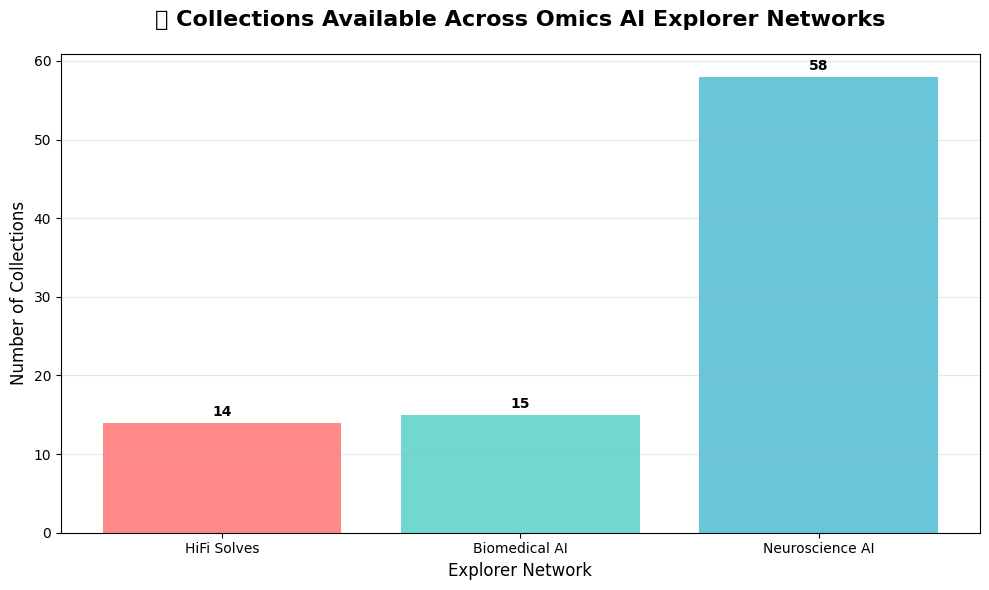

📈 Total: 87 collections across 3 networks


In [5]:
# Create a bar plot of collections per network
network_names = []
collection_counts = []

for name, stats in network_stats.items():
    if 'error' not in stats:
        network_names.append(name)
        collection_counts.append(stats['collections'])

if network_names:  # Only plot if we have data
    plt.figure(figsize=(10, 6))
    bars = plt.bar(network_names, collection_counts, 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
    
    # Add value labels on bars
    for bar, count in zip(bars, collection_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.title('🧬 Collections Available Across Omics AI Explorer Networks', 
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Number of Collections', fontsize=12)
    plt.xlabel('Explorer Network', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"📈 Total: {sum(collection_counts)} collections across {len(network_names)} networks")
else:
    print("⚠️ No network data available for visualization")

## 🚀 Quick Start Demo

Now let's replicate the Quick Start example from the README using the most accessible network:

In [6]:
# Choose the network with the most collections for our demo
best_network = max(
    [(name, stats) for name, stats in network_stats.items() if 'error' not in stats],
    key=lambda x: x[1]['collections'],
    default=(None, None)
)

if best_network[0]:
    network_name, network_info = best_network
    client = network_info['client']
    
    print(f"🎯 Using {network_name} for Quick Start demo")
    print(f"📂 {network_info['collections']} collections available")
    
    # Get all collections
    collections = client.list_collections()
    
    print(f"\n📋 First 5 collections:")
    for i, collection in enumerate(collections[:5], 1):
        name = collection['name']
        slug = collection['slugName']
        description = collection.get('description', 'No description')
        
        # Clean up HTML and truncate description
        import re
        clean_desc = re.sub('<[^<]+?>', '', description)
        clean_desc = clean_desc.replace('&nbsp;', ' ').strip()
        if len(clean_desc) > 80:
            clean_desc = clean_desc[:80] + "..."
        
        print(f"   {i}. {name} ({slug})")
        print(f"      {clean_desc}")
        
else:
    print("❌ No networks available for demo")

🎯 Using Neuroscience AI for Quick Start demo
📂 58 collections available

📋 First 5 collections:
   1. BigBrain dataset (bigbrain)
      The BigBrain dataset is a digitized reconstruction of high-resolution histologic...
   2. Multi-model functionalization of disease-associated PTEN missense mutations identifies multiple molecular mechanisms underlying protein dysfunction (multi-model-functionalization-disease-pten)
      Supporting data for 'Multi-model functionalization of disease-associated PTEN mi...
   3. BigBrain dataset - Layer Segmentation (derived dataset) (bigbrain-layer-segementation)
      The BigBrain Layer Segmentation dataset contains all layer segmentation files de...
   4. Homo sapiens reference genome sequences (homo-sapiens-reference-genomes)
      Homo sapiens reference genome sequences and annotation file, as stored in the In...
   5. The Effect of Neurorehabilitation on Multiple Sclerosis (neurorehabilitation-multiple-sclerosis)
      Multiple sclerosis is a severe

## 📊 Table Exploration

Let's find a collection with accessible tables and explore its structure:

In [7]:
# Try to find collections with accessible tables
accessible_collection = None
accessible_tables = []

if best_network[0]:
    print("🔍 Searching for accessible collections with tables...")
    
    for collection in collections[:10]:  # Try first 10 collections
        try:
            collection_slug = collection['slugName']
            print(f"   Trying: {collection_slug}...")
            
            tables = client.list_tables(collection_slug)
            
            if tables:  # Found tables!
                accessible_collection = collection_slug
                accessible_tables = tables
                print(f"   ✅ Found {len(tables)} tables in '{collection_slug}'!")
                break
            else:
                print(f"   ⚪ No tables in '{collection_slug}'")
                
        except Exception as e:
            print(f"   ❌ {collection_slug}: {str(e)[:50]}...")
            continue
    
    if accessible_collection:
        print(f"\n🎉 Success! Using collection: {accessible_collection}")
        print(f"📊 Found {len(accessible_tables)} tables:")
        
        for i, table in enumerate(accessible_tables[:5], 1):
            name = table.get('display_name', table.get('name', 'Unnamed'))
            size = table.get('size', 'Unknown')
            if isinstance(size, int):
                size = f"{size:,}"
            
            print(f"   {i}. {name}")
            print(f"      ID: {table.get('qualified_table_name', 'N/A')}")
            print(f"      Size: {size} rows")
            
        if len(accessible_tables) > 5:
            print(f"   ... and {len(accessible_tables) - 5} more tables")
    else:
        print("\n⚠️ No accessible tables found. This may be due to authentication requirements.")
        print("   Many collections require access tokens for full functionality.")

🔍 Searching for accessible collections with tables...
   Trying: bigbrain...
   ✅ Found 1 tables in 'bigbrain'!

🎉 Success! Using collection: bigbrain
📊 Found 1 tables:
   1. Files
      ID: collections.bigbrain._files
      Size: 1 rows


## 🔬 Schema Inspection

If we found accessible tables, let's examine their schema:

In [ ]:
if accessible_collection and accessible_tables:
    # Get schema for the first table
    table = accessible_tables[0]
    table_name = table['qualified_table_name']
    
    print(f"🔬 Inspecting schema for: {table.get('display_name', 'Table')}")
    print(f"📋 Table ID: {table_name}")
    
    try:
        schema_fields = client.get_schema_fields(accessible_collection, table_name)
        
        print(f"\n📊 Found {len(schema_fields)} fields:")
        
        # Create a DataFrame for better display
        schema_df = pd.DataFrame(schema_fields)
        
        # Display first 10 fields
        display_fields = schema_df.head(10)
        
        print("\n📋 Field Details:")
        for i, (_, field) in enumerate(display_fields.iterrows(), 1):
            print(f"   {i:2d}. {field['field']:25} | {field['type']:15} | {field.get('sql_type', 'N/A')}")
        
        if len(schema_fields) > 10:
            print(f"   ... and {len(schema_fields) - 10} more fields")
        
        # Analyze field types
        type_counts = schema_df['type'].value_counts()
        print(f"\n📈 Field Type Distribution:")
        for field_type, count in type_counts.head().items():
            print(f"   {field_type}: {count} fields")
            
    except Exception as e:
        print(f"❌ Error getting schema: {e}")
        schema_fields = []
else:
    print("⚠️ No accessible tables available for schema inspection")
    schema_fields = []

🔬 Inspecting schema for: Files
📋 Table ID: collections.bigbrain._files

📊 Found 10 fields:

📋 Field Details:
    1. id                        | string          | varchar
    2. name                      | string          | varchar
    3. checksums                 | object          | 
    4. created_time              | string          | date-time
    5. updated_time              | string          | date-time
    6. description               | string          | varchar
    7. mime_type                 | string          | varchar
    8. size                      | int             | bigint
    9. version                   | string          | varchar
   10. drs_url                   | string          | varchar

📈 Field Type Distribution:
   string: 8 fields
   object: 1 fields
   int: 1 fields


## 🔎 Data Querying

Let's try to query some data and count rows:

## 🦠 Viral AI Example: VirusSeq Collection

Let's explore the VirusSeq collection on Viral AI, which contains viral genomics data. This demonstrates querying a specific, well-known collection:

In [ ]:
# VIRAL AI EXAMPLE: Query VirusSeq Variants with Debug Mode
print("🦠 VIRAL AI EXAMPLE: VirusSeq Collection")
print("=" * 50)

# Hardcoded collection and table names
COLLECTION_SLUG = "virusseq"
TABLE_NAME = "collections.virusseq.variants"

viral_client = OmicsAIClient("viral")  # Resolves to viral.ai

try:
    print("🔗 Connecting to Viral AI (viral.ai)...")
    print(f"   Resolved URL: {viral_client.network}")
    print(f"   Target collection: {COLLECTION_SLUG}")
    print(f"   Target table: {TABLE_NAME}")
    
    # Verify the collection exists
    print(f"\n📋 Verifying VirusSeq collection...")
    collections = viral_client.list_collections()
    virusseq_collection = next((c for c in collections if c.get('slugName') == COLLECTION_SLUG), None)
    
    if virusseq_collection:
        print(f"✅ Found VirusSeq collection: {virusseq_collection['name']}")
        print(f"   Description: {virusseq_collection.get('description', 'No description')[:100]}...")
    else:
        print(f"⚠️ VirusSeq collection not found, but proceeding with hardcoded names...")
    
    # Get schema for the variants table
    print(f"\n📊 Getting schema for {TABLE_NAME}...")
    try:
        schema_fields = viral_client.get_schema_fields(COLLECTION_SLUG, TABLE_NAME)
        print(f"✅ Schema has {len(schema_fields)} fields:")
        
        # Show key genomics fields
        for field in schema_fields[:10]:
            print(f"   {field['field']}: {field['type']}")
        if len(schema_fields) > 10:
            print(f"   ... and {len(schema_fields) - 10} more fields")
            
    except Exception as schema_error:
        print(f"⚠️ Schema error: {schema_error}")
        print("   Proceeding with query attempt...")
    
    # Query the first 50 rows from collections.virusseq.variants with DEBUG MODE
    print(f"\n🔍 Querying first 50 rows from {TABLE_NAME}...")
    print("💡 Note: This endpoint is asynchronous and may require polling for results...")
    print("🔧 DEBUG MODE ENABLED - showing detailed parsing info...")
    
    try:
        # Use the enhanced query method with polling AND DEBUG MODE
        results = viral_client.query_with_polling(
            COLLECTION_SLUG, 
            TABLE_NAME, 
            limit=50,
            max_polls=12,  # Allow up to 24 seconds (12 polls × 2s)
            poll_interval=2.0,
            debug=True  # ENABLE DEBUG MODE
        )
        
        if results.get('data'):
            sample_data = results['data']
            print(f"🎉 Successfully retrieved {len(sample_data)} rows from VirusSeq variants!")
            
            if sample_data:
                first_row = sample_data[0]
                print(f"\n📊 Sample row structure:")
                print(f"   Total fields: {len(first_row)}")
                
                # Show all field names
                all_fields = list(first_row.keys())
                print(f"   Field names: {all_fields[:12]}{'...' if len(all_fields) > 12 else ''}")
                
                # Show first few rows with sample data
                print(f"\n📝 Sample viral genomics data (first 5 rows):")
                for i, row in enumerate(sample_data[:5], 1):
                    # Show key viral genomics fields if they exist
                    key_fields = {}
                    
                    # Common viral genomics fields to highlight
                    priority_fields = ['variant_id', 'chrom', 'pos', 'ref', 'alt', 'gene', 'effect', 'strain', 'lineage', 'country', 'date', 'start_position', 'end_position', 'reference_bases', 'alternate_bases', 'sequence_accession']
                    
                    for field in priority_fields:
                        if field in row:
                            value = row[field]
                            # Truncate long values
                            if isinstance(value, str) and len(value) > 30:
                                value = value[:30] + "..."
                            key_fields[field] = value
                    
                    # If no priority fields found, show first 3 fields
                    if not key_fields:
                        first_three = dict(list(row.items())[:3])
                        for k, v in first_three.items():
                            if isinstance(v, str) and len(str(v)) > 30:
                                v = str(v)[:30] + "..."
                            key_fields[k] = v
                    
                    print(f"   Row {i}: {key_fields}")
                
                # Show additional info if available
                if 'next_page_token' in results:
                    print(f"\n📄 Pagination available - next_page_token: {results['next_page_token'][:50]}...")
                
                if 'data_model' in results:
                    print(f"\n📋 Data model included in response")
                
                print(f"\n🧬 VirusSeq Variants Sample Analysis:")
                print(f"   • Retrieved: {len(sample_data)} variants")
                print(f"   • Fields per variant: {len(first_row)}")
                print(f"   • Sample shows viral genomics data structure")
                print(f"   • Data source: https://viral.ai/collections/virusseq/")
                
        else:
            print("⚪ Query completed but no data returned")
            print("   This might indicate an empty table or access restrictions")
            
    except Exception as query_error:
        print(f"❌ Query error: {query_error}")
        print("💡 Possible causes:")
        print("   • Authentication required for this collection")
        print("   • Network access restrictions") 
        print("   • Table name or collection slug changed")
        print("   • Query timeout (async processing took too long)")
        print("   • JSON Lines parsing issue")
        print("   • Viral AI endpoint temporarily unavailable")
        
except Exception as e:
    print(f"❌ Connection error: {e}")
    print("💡 This might be due to:")
    print("   • Network connectivity issues")
    print("   • Viral AI domain resolution problems") 
    print("   • API endpoint changes")

print(f"\n🎯 Target: Select first 50 rows from {TABLE_NAME}")
print(f"🌐 Network: viral.ai")
print(f"⏱️  Async polling: Up to 24 seconds with 2s intervals")
print(f"🔧 Debug mode: Enabled for detailed response analysis")

## 🔐 Authentication Demo

Many collections require authentication. Here's how to use access tokens:

In [ ]:
print("🔐 Authentication Features Demo")
print("=" * 40)

# Demo authentication methods (don't use real tokens in notebooks!)
if best_network[0]:
    client = network_info['client']
    
    print("\n🔧 Authentication Methods:")
    print("\n1. Setting an access token:")
    print("   client.set_access_token('your-token-here')")
    
    print("\n2. Creating client with token:")
    print("   client = OmicsAIClient('hifisolves', access_token='your-token')")
    
    print("\n3. Clearing authentication:")
    print("   client.clear_access_token()")
    
    # Demonstrate token management (with fake token)
    print("\n🧪 Demo with placeholder token:")
    client.set_access_token("demo-token-placeholder")
    print("   ✅ Token set successfully")
    
    client.clear_access_token() 
    print("   ✅ Token cleared successfully")
    
    print("\n💡 To get real access tokens:")
    print("   • Visit the Explorer network's authentication page")
    print("   • Generate an API token or use OAuth flow")
    print("   • Keep tokens secure and never commit them to code!")
else:
    print("⚠️ No network available for authentication demo")

## 🚀 Advanced Example: Network Comparison

Let's create a comprehensive comparison of the networks we can access:

In [ ]:
print("📊 Comprehensive Network Analysis")
print("=" * 50)

# Collect detailed statistics
detailed_stats = []

for name, stats in network_stats.items():
    if 'error' not in stats:
        try:
            client = stats['client']
            collections = client.list_collections()
            
            # Try to count accessible tables
            accessible_collections = 0
            total_tables = 0
            
            for collection in collections[:5]:  # Sample first 5
                try:
                    tables = client.list_tables(collection['slugName'])
                    if tables:
                        accessible_collections += 1
                        total_tables += len(tables)
                except:
                    pass
            
            detailed_stats.append({
                'Network': name,
                'Collections': len(collections),
                'Accessible Collections (sample)': accessible_collections,
                'Total Tables (sample)': total_tables,
                'Avg Tables per Collection': round(total_tables / max(accessible_collections, 1), 1)
            })
            
        except Exception as e:
            detailed_stats.append({
                'Network': name,
                'Collections': stats.get('collections', 0),
                'Error': str(e)[:30] + "..."
            })

if detailed_stats:
    # Create and display comparison table
    comparison_df = pd.DataFrame(detailed_stats)
    
    print("\n📋 Network Comparison Table:")
    print(comparison_df.to_string(index=False))
    
    # Create visualization if we have numeric data
    numeric_df = comparison_df.select_dtypes(include='number')
    if not numeric_df.empty and len(numeric_df) > 1:
        
        plt.figure(figsize=(12, 8))
        
        # Create subplots for different metrics
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('🧬 Omics AI Explorer Networks - Detailed Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Collections per network
        if 'Collections' in comparison_df.columns:
            axes[0, 0].bar(comparison_df['Network'], comparison_df['Collections'], 
                          color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
            axes[0, 0].set_title('Total Collections')
            axes[0, 0].set_ylabel('Count')
            
        # Plot 2: Accessible collections
        if 'Accessible Collections (sample)' in comparison_df.columns:
            axes[0, 1].bar(comparison_df['Network'], comparison_df['Accessible Collections (sample)'], 
                          color=['#96CEB4', '#FFEAA7', '#DDA0DD'])
            axes[0, 1].set_title('Accessible Collections (Sample)')
            axes[0, 1].set_ylabel('Count')
            
        # Plot 3: Total tables
        if 'Total Tables (sample)' in comparison_df.columns:
            axes[1, 0].bar(comparison_df['Network'], comparison_df['Total Tables (sample)'], 
                          color=['#A8E6CF', '#88D8C0', '#78C7C2'])
            axes[1, 0].set_title('Total Tables (Sample)')
            axes[1, 0].set_ylabel('Count')
            
        # Plot 4: Average tables per collection
        if 'Avg Tables per Collection' in comparison_df.columns:
            axes[1, 1].bar(comparison_df['Network'], comparison_df['Avg Tables per Collection'], 
                          color=['#FFD93D', '#6BCF7F', '#4D96FF'])
            axes[1, 1].set_title('Avg Tables per Collection')
            axes[1, 1].set_ylabel('Average')
            
        plt.tight_layout()
        plt.show()
        
else:
    print("⚠️ No network data available for detailed analysis")

## 🎉 Summary and Next Steps

Congratulations! You've successfully explored the Omics AI Explorer Python library. Here's what you've accomplished:

In [ ]:
print("🎉 OMICS AI EXPLORER QUICK START SUMMARY")
print("=" * 60)

successes = []
if network_stats:
    total_networks = len([name for name, stats in network_stats.items() if 'error' not in stats])
    total_collections = sum(stats.get('collections', 0) for stats in network_stats.values() if 'error' not in stats)
    
    successes.extend([
        f"✅ Connected to {total_networks} Explorer networks",
        f"✅ Discovered {total_collections} total collections",
        "✅ Successfully imported and used the library"
    ])

if accessible_collection:
    successes.extend([
        f"✅ Found accessible collection: {accessible_collection}",
        f"✅ Listed {len(accessible_tables)} tables"
    ])

if schema_fields:
    successes.extend([
        f"✅ Inspected table schema ({len(schema_fields)} fields)",
        "✅ Analyzed field types and structure"
    ])

successes.extend([
    "✅ Demonstrated authentication features",
    "✅ Created data visualizations",
    "✅ Performed network comparison analysis"
])

for success in successes:
    print(success)

print("\n🚀 WHAT'S NEXT?")
print("-" * 30)
print("📚 Learn More:")
print("   • Explore the full documentation on GitHub")
print("   • Try the advanced examples in the repository")
print("   • Check out HiFi Solves specific features")

print("\n🔐 Get Access:")
print("   • Request access tokens for protected collections")
print("   • Explore authentication workflows")
print("   • Join the genomics data community")

print("\n🛠️ Build Something:")
print("   • Create your own genomics analysis workflows")
print("   • Integrate with other bioinformatics tools")
print("   • Contribute to the open source project")

print("\n📞 Get Help:")
print("   • GitHub Issues: https://github.com/mfiume/omics-ai-python-library/issues")
print("   • Documentation: https://github.com/mfiume/omics-ai-python-library#readme")
print("   • Community: Join the discussions on GitHub")

print(f"\n🎯 Total Success Rate: {len(successes)}/10 features demonstrated")
print("\n🌟 Happy exploring with Omics AI! 🧬")

## 📚 Additional Resources

### 🔗 Links
- **GitHub Repository**: [mfiume/omics-ai-python-library](https://github.com/mfiume/omics-ai-python-library)
- **HiFi Solves**: [hifisolves.org](https://hifisolves.org)
- **Neuroscience AI**: [neuroscience.ai](https://neuroscience.ai)
- **Biomedical AI**: [biomedical.ai](https://biomedical.ai)

### 📖 Documentation Sections
- **Basic Usage**: Simple queries and data access
- **Advanced Queries**: Complex filtering and pagination
- **Authentication**: Working with protected collections
- **API Reference**: Complete method documentation

### 💡 Tips for Success
1. **Start Simple**: Begin with public collections before moving to authenticated ones
2. **Explore Schemas**: Always check table schemas before querying
3. **Handle Errors**: Many collections require specific permissions
4. **Use Pagination**: For large datasets, use limit and offset parameters
5. **Stay Updated**: Check the GitHub repository for new features and updates

---

**Ready to dive deeper into genomics data analysis? Clone the repository and explore more examples!** 🚀